# Experimentation autoencoder and UMAP

In [1]:
import junodch_utils_read_img as utils

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback

import rasterio
import keras
from keras import layers

import umap
from umap.parametric_umap import ParametricUMAP

# Data preparation
### Fetch data from file

In [2]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night_VIIRS.tif"
pathValidation = folderName + "Population_GHSL.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)
print('Tiles:',dataCoords.shape[0])


Tiles: 139113


In [3]:
lightMask = (dataRadiance>0)
lightCoords = dataCoords[lightMask]
darkMask = (dataRadiance==0)

idxDarkData = np.random.choice(np.arange(dataCoords.shape[0])[darkMask], len(lightCoords), replace=False)
darkCoords = dataCoords[idxDarkData]

trainCoords = np.concatenate((lightCoords, darkCoords))

with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.coordsToImgsFormated(f, trainCoords, res=64)
print(trainData.shape)

print('Light Tile:',len(lightCoords))
print('dark Tile:',len(darkCoords))
print('Total train',trainData.shape)

(1378, 64, 64, 3)
Light Tile: 689
dark Tile: 689
Total train (1378, 64, 64, 3)


# UMAP

In [4]:
autoencoder = keras.models.load_model('model/autoencoder_64px_encoder_1024')
encoder = keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('encoder').output)

trainDataUmap = encoder.predict(trainData)
validation = np.concatenate((dataRadiance[lightMask], dataRadiance[idxDarkData]))

print(trainDataUmap.shape)

44/44 [==============================] - 1s 6ms/step
(1378, 1024)


In [5]:
def displayResultUMAP(embedding):
  fig, ax2 = plt.subplots( figsize=(5, 4))
  sc = ax2.scatter(
      embedding[:, 0],
      embedding[:, 1],
      c= validation,
      cmap='rainbow',
      s=5,
      alpha=0.3,
      rasterized=True,
  )
  ax2.axis('equal')
  plt.colorbar(sc, ax=ax2)

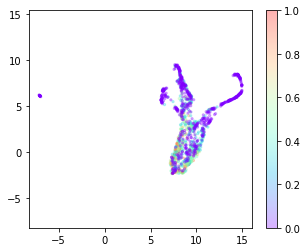

In [6]:
embedding = umap.UMAP(random_state=50).fit_transform(trainDataUmap)
displayResultUMAP(embedding)